# Text As Data Coursework
<font color='blue'>**Total Marks - 58**</font>

**Introduction** <br>

The TaD coding coursework aims to assess your abilities to perform text processing techniques as applied to a 
multi-class classification problem. <br>
Your work will be submitted through a Moodle quiz. For each question, you should submit your text answer 
(providing the required information) separately to your code. 

**Task:** <br>
A museum records organisation has a large set of records that need to be assigned to one of five 
institutions (in the table below). They have provided a small set of data to be used as the training, validation and test 
set. Our goal is to build a classifier that could assign an unseen record to the correct institution. 

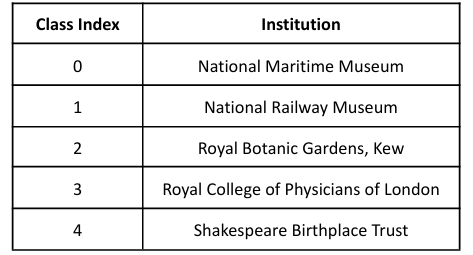

## Import Libraries

In [1]:
import os
import json
import math
import spacy
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

## Data Cleaning
*<font color='Purple'>Marks - 9</font>*

**Task** -
- Download and load the dataset. There are some issues with the training split of the data that would stop it being used to train a classifier.
- Report all issues and how you fixed them.

In [2]:
# Read dataset
with open('./Data/dataset.json', 'r') as file:
    data = json.load(file)

In [3]:
# Read LLM Prompt Template 1
with open('./Data/llm_prompt_template_1.json', 'r') as file:
    LLM_PromptTemplate1 = json.load(file)

In [4]:
# Read LLM Prompt Template 2
with open('./Data/llm_prompt_template_2.json', 'r') as file:
    LLM_PromptTemplate2 = json.load(file)

In [5]:
# Read LLM Prompt Template 3
with open('./Data/llm_prompt_template_3.json', 'r') as file:
    LLM_PromptTemplate3 = json.load(file)

Just looking at the dataset, I can tell that we have two apparent problems.

First, different-different keys for similar fields. For example:
- We have json objects, with similar fields such as *key*, *label*, and *labl*
- Similarly, we have json objects, with similar fields such as *content*, *text*, and *description*

Second problem:
- Labels are wrong, sometimes it has integer value and sometimes it has a text value.

Third problem:
- A few samples of the training datasets are None type.

In [6]:
trainingSet = data["train"]
validationSet = data["val"]
testSet = data["test"]

In [7]:
uniqueKeys = set()
for sample in trainingSet:
    for x in sample.keys():
        uniqueKeys.add(x)
print("Unique keys in Training dataset: ", uniqueKeys)

Unique keys in Training dataset:  {'label', 'key', 'id', 'text', 'description', 'content', 'labl'}


Unique Keys: {'label', 'id', 'text', 'labl', 'content', 'key', 'description'} <br>
This confirms our suspicion for the First problem.

**Solution**
- We should choose a single key for each such fields and stick with it.
  - Choosing "*content*" and "*label*"
    - **Reason**: Both Validation and Test set has these two keys


In [8]:
for i in range(0, len(trainingSet)):
    dictKeys = trainingSet[i].keys()
    if("labl" in dictKeys):
        trainingSet[i]["label"] = trainingSet[i].pop("labl")
    elif("key" in dictKeys):
        trainingSet[i]["label"] = trainingSet[i].pop("key")

    if("description" in dictKeys):
        trainingSet[i]["content"] = trainingSet[i].pop("description")
    elif("text" in dictKeys):
        trainingSet[i]["content"] = trainingSet[i].pop("text")

Now, let's again check unique number of keys we have.

In [9]:
uniqueKeys = set()
for sample in trainingSet:
    for x in sample.keys():
        uniqueKeys.add(x)
print("Unique keys in Training dataset: ", uniqueKeys)

Unique keys in Training dataset:  {'label', 'content', 'id'}


Now, that we have solved the first problem, let's focus on the second problem. The problem is that, for label field we have both integer and text values. Sometimes, even those text values doesn't match with the Institution names provided. <br>
**Solution**:
- First, convert wrong text values to correct values.
- Then, convert all text values to an integer values.

In [10]:
actualClasses = [
    "national maritime museum",
    "national railway museum",
    "royal botanic gardens, kew",
    "royal college of physicians of london",
    "shakespeare birthplace trust"
]
classDict = {
    "national maritime museum": 0,
    "national railway museum": 1,
    "royal botanic gardens, kew": 2,
    "royal college of physicians of london": 3,
    "shakespeare birthplace trust": 4
}

In [11]:
for i in range(0, len(trainingSet)):
    if(str(trainingSet[i]["label"]).lower() not in actualClasses and type(trainingSet[i]["label"]) == str):
        if("maritime" in trainingSet[i]["label"].lower()):
            trainingSet[i]["label"] = actualClasses[0]
        elif("railway" in data["train"][i]["label"].lower()):
            trainingSet[i]["label"] = actualClasses[1]
        elif("botanic" in trainingSet[i]["label"].lower() or "kew" in trainingSet[i]["label"].lower()):
            trainingSet[i]["label"] = actualClasses[2]
        elif("london" in trainingSet[i]["label"].lower() or "physicians" in trainingSet[i]["label"].lower()):
            trainingSet[i]["label"] = actualClasses[3]
        elif("shakespeare" in trainingSet[i]["label"].lower() or "birthplace" in trainingSet[i]["label"].lower()):
            trainingSet[i]["label"] = actualClasses[4]
        else:
            print("-----------------------")
            print("HERE!! NO CLASS FOUND!!")
            print("Label: ", trainingSet[i]["label"])

    if(type(trainingSet[i]["label"]) == str and str(trainingSet[i]["label"]).lower() in actualClasses):
        trainingSet[i]["label"] = classDict[trainingSet[i]["label"].lower()]

Now, let's check if all the labels exist between 0 and 4

In [12]:
labels = set()
for i in range(0, len(trainingSet)):
    labels.add(trainingSet[i]["label"])
print("Unique Labels in Training Set: ", labels)

Unique Labels in Training Set:  {0, 1, 2, 3, 4}


To solve the third problem, we have to remove those samples. <br>
**Solution** - 
- Convert all content to string values.

In [13]:
i = 0
while(i < len(trainingSet)):
    if(type(trainingSet[i]['content']) != str):
        print(trainingSet[i])
        trainingSet.remove(trainingSet[i])
    else:
        i += 1

{'id': '7ab43067-856c-5cee-8574-ac59a24de44b', 'label': 2, 'content': None}
{'id': '7148fce2-2315-1826-2615-05abd9b0b806', 'label': 1, 'content': 258157}
{'id': 'aa985a46-605f-2be7-12ba-9204d8d240e4', 'content': 829308, 'label': 4}
{'id': '95a0d569-602a-5bdc-06ca-62eb08302d3d', 'label': 1, 'content': None}
{'id': '246aeb01-6686-57ab-9f4e-3a15f01446e5', 'label': 3, 'content': 535970}


In [14]:
print("Length of Training Set: ", len(trainingSet))

Length of Training Set:  150


Let's fix the problem in Validation and Test Set, since both have labels in STRING format. <br>
**Solution** -
- Convert them to Integer format.

In [15]:
for i in range(0, len(validationSet)):
    if(validationSet[i]['label'].lower() in classDict.keys()):
        validationSet[i]['label'] = classDict[validationSet[i]['label'].lower()]
    else:
        print("This should never run. ALERT!! ALERT!!")
        print(validationSet[i]['label'])

In [16]:
for i in range(0, len(testSet)):
    if(testSet[i]['label'].lower() in classDict.keys()):
        testSet[i]['label'] = classDict[testSet[i]['label'].lower()]
    else:
        print("This should never run. ALERT!! ALERT!!")
        print(testSet[i]['label'])

## Exploration
*<font color='Purple'>Marks - 5</font>*

**Task** - <br>Once the training set has been fixed, report the following:
- The sample counts for the training, validation and test sets
- The percentage splits for training, validation and test sets
- The minimum and maximum length (in characters) of the texts.
  - Report separately for the training, validation and test sets
- The most frequent five tokens in each class (after tokenizing with `text_pipeline_spacy` from Lab 2)

### Sample Counts

In [17]:
print("Sample Count in Training Set: ", len(trainingSet))
print("Sample Count in Validation Set: ", len(validationSet))
print("Sample Count in Test Set: ", len(testSet))

Sample Count in Training Set:  150
Sample Count in Validation Set:  50
Sample Count in Test Set:  50


### Percentage Split between Training, Validation and Test Set

In [18]:
totalSamples = len(trainingSet) + len(validationSet) + len(testSet)

print("Percentage of Training Set from all dataset: ", round(len(trainingSet)/totalSamples * 100, 2))
print("Percentage of Validation Set from all dataset: ", round(len(validationSet)/totalSamples * 100, 2))
print("Percentage of Test Set from all dataset: ", round(len(testSet)/totalSamples * 100, 2))

Percentage of Training Set from all dataset:  60.0
Percentage of Validation Set from all dataset:  20.0
Percentage of Test Set from all dataset:  20.0


### Maximum and Minimum Lengths of Text from each dataset

In [19]:
def findExtremes(dataSet, textKey):
    maxLength, minLength = -math.inf, math.inf
    for sample in dataSet:
        if(sample[textKey] != None and len(sample[textKey]) > maxLength):
            maxLength = len(sample[textKey])
        if(sample[textKey] != None and len(sample[textKey]) < minLength):
            minLength = len(sample[textKey])
    return maxLength, minLength

In [20]:
maxLength, minLength = findExtremes(trainingSet, 'content')
print(f"Maximum Length of Text from Training Set is: {maxLength}")
print(f"Minimum Length of Text from Training Set is: {minLength}")

Maximum Length of Text from Training Set is: 4263
Minimum Length of Text from Training Set is: 163


In [21]:
maxLength, minLength = findExtremes(validationSet, 'content')
print(f"Maximum Length of Text from Validation Set is: {maxLength}")
print(f"Minimum Length of Text from Validation Set is: {minLength}")

Maximum Length of Text from Validation Set is: 2794
Minimum Length of Text from Validation Set is: 154


In [22]:
maxLength, minLength = findExtremes(testSet, 'content')
print(f"Maximum Length of Text from Test Set is: {maxLength}")
print(f"Minimum Length of Text from Test Set is: {minLength}")

Maximum Length of Text from Test Set is: 3479
Minimum Length of Text from Test Set is: 167


### Most Five Frequent Tokens

In [23]:
nlp = spacy.load("en_core_web_sm")

In [24]:
def text_pipeline_spacy(text):
    tokens = []
    doc = nlp(text)
    for t in doc:
        if not t.is_stop and not t.is_punct and not t.is_space:
            tokens.append(t.lemma_.lower())
    return tokens

def makeVocabulary(texts):
    tokenizedTexts = [text_pipeline_spacy(text) for text in texts]
    allTokens = [token for subList in tokenizedTexts for token in subList]
    return Counter(allTokens)

In [25]:
textsWithLabel0, textsWithLabel1, textsWithLabel2, textsWithLabel3, textsWithLabel4  = [], [], [], [], []
for sample in trainingSet:
    if(sample['label'] == 0 and sample['content'] != None):
        textsWithLabel0.append(sample['content'])
    elif(sample['label'] == 1 and sample['content'] != None):
        textsWithLabel1.append(sample['content'])
    elif(sample['label'] == 2 and sample['content'] != None):
        textsWithLabel2.append(sample['content'])
    elif(sample['label'] == 3 and sample['content'] != None):
        textsWithLabel3.append(sample['content'])
    elif(sample['label'] == 4 and sample['content'] != None):
        textsWithLabel4.append(sample['content'])

print("Top 5 tokens in Training Set for Class 0: ", makeVocabulary(textsWithLabel0).most_common(5))
print("Top 5 tokens in Training Set for Class 1: ", makeVocabulary(textsWithLabel1).most_common(5))
print("Top 5 tokens in Training Set for Class 2: ", makeVocabulary(textsWithLabel2).most_common(5))
print("Top 5 tokens in Training Set for Class 3: ", makeVocabulary(textsWithLabel3).most_common(5))
print("Top 5 tokens in Training Set for Class 4: ", makeVocabulary(textsWithLabel4).most_common(5))

Top 5 tokens in Training Set for Class 0:  [('john', 16), ('sir', 11), ('henry', 10), ('enclosure', 10), ('james', 9)]
Top 5 tokens in Training Set for Class 1:  [('2000', 144), ('7200', 144), ('756', 143), ('gb', 142), ('collection', 31)]
Top 5 tokens in Training Set for Class 2:  [('letter', 30), ('include', 15), ('paper', 14), ('list', 12), ('contain', 11)]
Top 5 tokens in Training Set for Class 3:  [('seal', 25), ('common', 21), ('mr.', 17), ('college', 17), ('fellow', 16)]
Top 5 tokens in Training Set for Class 4:  [('mr.', 18), ('work', 16), ('bill', 15), ('account', 14), ('letter', 14)]


## Prompting with a Large lLnguage Model (LLM)
*<font color='Purple'>Marks - 10</font>*

**Task** - <br>
A colleague has tried prompting a large language model (Llama-3.1-8B-Instruct) to classify each of the records in the training set. They evaluated three different prompt templates and saved the results to the provided files.
- Calculate the accuracy, macro precision, macro recall and macro F1 for each prompt template and comment on the result.
  - **Note** - Consider any invalid output from the LLM as predicting a sixth hypothetical class. 

In [26]:
def convertTemplates(promptTemplate, keys):
    promptCleaned = {}
    key1, key2, key3 = keys
    for prompt in promptTemplate:
        ID = prompt[key1]
        if(ID not in promptCleaned):
            try:
                promptLabel = int(prompt[key3])
            except:
                promptLabel = 5
            promptCleaned[ID] = {'prompt': prompt[key2], 'label': promptLabel}
    return promptCleaned

trainPrompts = convertTemplates(trainingSet, ['id', 'content', 'label'])
LLM_PromptTemplate1_Dict = convertTemplates(LLM_PromptTemplate1, ['id', 'prompt', 'next_token'])
LLM_PromptTemplate2_Dict = convertTemplates(LLM_PromptTemplate2, ['id', 'prompt', 'next_token'])
LLM_PromptTemplate3_Dict = convertTemplates(LLM_PromptTemplate3, ['id', 'prompt', 'next_token'])

In [27]:
labels = [0, 1, 2, 3, 4]

In [28]:
combinedData = []
for i in range(0, len(trainingSet)):
    ID = trainingSet[i]['id']
    combinedData.append([
        ID,
        trainingSet[i]['label'],
        LLM_PromptTemplate1_Dict[ID]['label'],
        LLM_PromptTemplate2_Dict[ID]['label'],
        LLM_PromptTemplate3_Dict[ID]['label'],
    ])
    
# Convert it to NumPy Array
combinedData = np.array(combinedData)
combinedData = pd.DataFrame(combinedData,
    columns = ['ID', 'Train_Labels', 'LLM1_Labels', 'LLM2_Labels', 'LLM3_Labels']
)
combinedData['Train_Labels'] = combinedData['Train_Labels'].astype(int)
combinedData['LLM1_Labels'] = combinedData['LLM1_Labels'].astype(int)
combinedData['LLM2_Labels'] = combinedData['LLM2_Labels'].astype(int)
combinedData['LLM3_Labels'] = combinedData['LLM3_Labels'].astype(int)

In [29]:
def calculateMetrics(trueLabels, predictedLabels):
    # Accuracy
    uniqueLabels = list(set(trueLabels).union(set(predictedLabels)))
    accuracy = accuracy_score(trueLabels, predictedLabels)
    
    # Precision, Recall, F1 for each class
    precision = precision_score(trueLabels, predictedLabels, average = None, labels = uniqueLabels)
    recall = recall_score(trueLabels, predictedLabels, average = None, labels = uniqueLabels)
    f1Score = f1_score(trueLabels, predictedLabels, average = None, labels = uniqueLabels)
    
    # Macro averages
    macroPrecision = np.mean(precision)
    macroRecall = np.mean(recall)
    macroF1 = np.mean(f1Score)
    
    # Confusion Matrix:
    if(len(uniqueLabels) == 5):
        cmIndex = ['Actual 0', 'Actual 1', 'Actual 2', 'Actual 3', 'Actual 4']
        cmColumns = ['Predicted 0', 'Predicted 1', 'Predicted 2', 'Predicted 3', 'Predicted 4']
        maIndex = ['0', '1', '2', '3', '4', 'Macro Average']
        maColumns = ['Precision', 'Recall', 'F1 Score', 'No of Actual Samples']
    elif(len(uniqueLabels) == 6):
        cmIndex = ['Actual 0', 'Actual 1', 'Actual 2', 'Actual 3', 'Actual 4', 'Actual 5']
        cmColumns = ['Predicted 0', 'Predicted 1', 'Predicted 2', 'Predicted 3', 'Predicted 4', 'Predicted 5']
        maIndex = ['0', '1', '2', '3', '4', '5', 'Macro Average']
        maColumns = ['Precision', 'Recall', 'F1 Score', 'No of Actual Samples']

    print("Confusion Matrix: ")
    confusionMatrix = pd.DataFrame(confusion_matrix(trueLabels, predictedLabels),
        index = cmIndex,
        columns = cmColumns
    )
    print(confusionMatrix.to_string(index = True))

    metricMatrix = np.array([[0] * 4 for i in range(0, len(uniqueLabels))], dtype = np.float32)
    metricMatrix[:, 0] = np.array(precision)
    metricMatrix[:, 1] = np.array(recall)
    metricMatrix[:, 2] = np.array(f1Score)
    metricMatrix[:, 3] = confusionMatrix.sum(axis = 1)
    metricMatrix = np.vstack([metricMatrix, [macroPrecision, macroRecall, macroF1, len(trueLabels)]])
    metricMatrix = pd.DataFrame(metricMatrix, 
         index = maIndex,
         columns = maColumns
    )

    print("\n\n")
    # Print results
    print(f"Accuracy: {accuracy}")
    print(metricMatrix)
    return macroPrecision, macroRecall, macroF1

In [30]:
print("LLM Prompt Template 1: ")
LLM1_Precision, LLM1_Recall, LLM1_F1Score = calculateMetrics(combinedData['Train_Labels'], combinedData['LLM1_Labels'])

LLM Prompt Template 1: 
Confusion Matrix: 
          Predicted 0  Predicted 1  Predicted 2  Predicted 3  Predicted 4  Predicted 5
Actual 0            0            0            0            0            0           29
Actual 1            0            0            0            0            0           33
Actual 2            0            0            0            0            0           28
Actual 3            0            0            0            0            0           31
Actual 4            0            0            0            0            0           29
Actual 5            0            0            0            0            0            0



Accuracy: 0.0
               Precision  Recall  F1 Score  No of Actual Samples
0                    0.0     0.0       0.0                  29.0
1                    0.0     0.0       0.0                  33.0
2                    0.0     0.0       0.0                  28.0
3                    0.0     0.0       0.0                  31.0
4     

C:\Users\nikkg\anaconda3\envs\ds_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nikkg\anaconda3\envs\ds_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [31]:
print("LLM Prompt Template 2: ")
LLM2_Precision, LLM2_Recall, LLM2_F1Score = calculateMetrics(combinedData['Train_Labels'], combinedData['LLM2_Labels'])

LLM Prompt Template 2: 
Confusion Matrix: 
          Predicted 0  Predicted 1  Predicted 2  Predicted 3  Predicted 4
Actual 0           25            2            1            1            0
Actual 1            3           29            1            0            0
Actual 2            2            0           22            2            2
Actual 3            2            0            1           28            0
Actual 4            6            0            0           13           10



Accuracy: 0.76
               Precision    Recall  F1 Score  No of Actual Samples
0               0.657895  0.862069  0.746269                  29.0
1               0.935484  0.878788  0.906250                  33.0
2               0.880000  0.785714  0.830189                  28.0
3               0.636364  0.903226  0.746667                  31.0
4               0.833333  0.344828  0.487805                  29.0
Macro Average   0.788615  0.754925  0.743436                 150.0


In [32]:
print("LLM Prompt Template 3: ")
LLM3_Precision, LLM3_Recall, LLM3_F1Score = calculateMetrics(combinedData['Train_Labels'], combinedData['LLM3_Labels'])

LLM Prompt Template 3: 
Confusion Matrix: 
          Predicted 0  Predicted 1  Predicted 2  Predicted 3  Predicted 4  Predicted 5
Actual 0           24            1            1            1            0            2
Actual 1            2           30            1            0            0            0
Actual 2            2            1           20            1            1            3
Actual 3            5            0            0           26            0            0
Actual 4           20            0            1            0            6            2
Actual 5            0            0            0            0            0            0



Accuracy: 0.7066666666666667
               Precision    Recall  F1 Score  No of Actual Samples
0               0.452830  0.827586  0.585366                  29.0
1               0.937500  0.909091  0.923077                  33.0
2               0.869565  0.714286  0.784314                  28.0
3               0.928571  0.838710  0.881356    

C:\Users\nikkg\anaconda3\envs\ds_env\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Comment on the Result Obtained

##  Fine-tune a Transformer
*<font color='Purple'>Marks - 10</font>*

**Task** - <br>
- Fine-tune a ‘bert-base-uncased’ transformer model on the model using the training set.
   - **Note**: You should use an **AutoModelForSequenceClassification** and the **HuggingFace** trainer.
- Use **8 epochs**, a **learning_rate** of **5e-5** and a batch size of **8**.
- Evaluate on the validation set.
- Report the per-class precision, recall and F1 score as well as the accuracy, macro precision, macro recall and macro F1 score.

**Note** - Don’t be surprised with poor performance (see the next question) 

In [33]:
import torch
from datasets import Dataset
from sklearn.metrics import f1_score
from transformers import pipeline
from transformers import AutoConfig
from transformers import AutoTokenizer
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from transformers import set_seed, AutoModelForSequenceClassification

set_seed(42)

In [34]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the dataset
def tokenize_function(examples, tokenizer):
    return tokenizer(examples['content'], padding = "max_length", truncation = True, return_tensors = "pt", max_length = 512)

In [35]:
# Convert the list of dictionaries to a Hugging Face Dataset
trainDataset = Dataset.from_dict({
    'id': [d['id'] for d in trainingSet],
    'content': [d['content'] for d in trainingSet],
    'label': [d['label'] for d in trainingSet]
})

In [36]:
# Convert the list of dictionaries to a Hugging Face Dataset
validationDataset = Dataset.from_dict({
    'id': [d['id'] for d in validationSet],
    'content': [d['content'] for d in validationSet],
    'label': [d['label'] for d in validationSet]
})

In [37]:
# Convert the list of dictionaries to a Hugging Face Dataset
testDataset = Dataset.from_dict({
    'id': [d['id'] for d in testSet],
    'content': [d['content'] for d in testSet],
    'label': [d['label'] for d in testSet]
})

In [38]:
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
learningRate = 5e-5
batchSize = 8
epochs = 8
weightDecay = 0.1

In [40]:
trainingArguments = TrainingArguments(
    output_dir = "TAD_Coursework",
    eval_strategy = "epoch",
    num_train_epochs = epochs,
    per_device_train_batch_size = batchSize,
    per_device_eval_batch_size = batchSize,
    learning_rate = learningRate,
    weight_decay = weightDecay,
    report_to = 'none',
    logging_steps = 10
)

In [41]:
dataCollator = DataCollatorWithPadding(tokenizer = tokenizer)
trainer = Trainer(
    model = model,
    args = trainingArguments,
    train_dataset = trainDataset.map(lambda x: tokenize_function(x, tokenizer), batched = True),
    eval_dataset = validationDataset.map(lambda x: tokenize_function(x, tokenizer), batched = True),
    data_collator = dataCollator,
)

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [42]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,1.611000,1.718849
2,1.200000,1.918974
3,0.612900,2.296982
4,0.223800,2.811447
5,0.078200,3.539253
6,0.026500,3.947955
7,0.018200,4.086780
8,0.014300,4.138451


TrainOutput(global_step=152, training_loss=0.44828743050119985, metrics={'train_runtime': 67.7463, 'train_samples_per_second': 17.713, 'train_steps_per_second': 2.244, 'total_flos': 315741770956800.0, 'train_loss': 0.44828743050119985, 'epoch': 8.0})

In [43]:
tokenizedValidationDataset = validationDataset.map(lambda x: tokenize_function(x, tokenizer), batched = True)
predictions, label_ids, metrics = trainer.predict(tokenizedValidationDataset)

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

## A Problem with the Validation Set
*<font color='Purple'>Marks - 5</font>*

**Task** - <br>
There is an issue with the validation set which causes poor performance.
- Provide the confusion matrix.
- Describe the problem, how you identified it and how you fixed it. 

In [44]:
predictedValidationLabels = np.argmax(predictions, axis = 1)
print("Validation Set: ")
Val_Precision, Val_Recall, Val_F1Score = calculateMetrics(tokenizedValidationDataset['label'], predictedValidationLabels)

Validation Set: 
Confusion Matrix: 
          Predicted 0  Predicted 1  Predicted 2  Predicted 3  Predicted 4
Actual 0            1            0            0            0            7
Actual 1            0            0            3           10            0
Actual 2            0            0           11            0            0
Actual 3            0            9            1            0            0
Actual 4            7            0            0            1            0



Accuracy: 0.24
               Precision  Recall  F1 Score  No of Actual Samples
0               0.125000   0.125  0.125000                   8.0
1               0.000000   0.000  0.000000                  13.0
2               0.733333   1.000  0.846154                  11.0
3               0.000000   0.000  0.000000                  10.0
4               0.000000   0.000  0.000000                   8.0
Macro Average   0.171667   0.225  0.194231                  50.0


Just looking at the **Confusion Matrix**, one can assume the samples are accidently labeled wrong. Since,
- All samples with Label 0 are Predicted as Label 4 and vice versa.
- Similarly, all the samples with Label 1 are Predicted as Label 3 and vice versa.

Let's check our suspicioun.

In [45]:
print("Label 0 is supposed to be for Institution: National Maritime Museum")
print("Label 4 is supposed to be for Institution: Shakespeare Birthplace Trust\n")
for i in range(0, len(validationSet)):
    if(validationSet[i]['label'] == 0):
        print(validationSet[i]['content'])
        print("\n")

Label 0 is supposed to be for Institution: National Maritime Museum
Label 4 is supposed to be for Institution: Shakespeare Birthplace Trust

Memorandum 'Item to knowe whether hyt be lawfull fr ye xij men that were sworne to gyve verdyt on hyt or no seyng the sheryf and bayles are changed. Also whether hyt be lawfull for the new shyryfe & bayles to [?] the same men syng they knowe not who they are but by the ynformatyon of the partyes'


Thomas Garth, Philip Philips, G.Payne to [Edward Earl of Orford] Letter, duplicate copy. Having received letters of attorney they now enclose their accounts showing the balance due to Col. Francis Russell's executors. He will be surprised at the amount of the debts of which they, who were daily with the Colonel, knew little though they have paid only what debts could be proved. They explain the plan adopted for getting a certain £300 from the government, and mention some matters relating to infringement of the secretary's rights, and papers which are be

In [46]:
print("Label 4 is supposed to be for Institution: Shakespeare Birthplace Trust")
print("Label 0 is supposed to be for Institution: National Maritime Museum\n")
for i in range(0, len(validationSet)):
    if(validationSet[i]['label'] == 4):
        print(validationSet[i]['content'])
        print("\n")

Label 4 is supposed to be for Institution: Shakespeare Birthplace Trust
Label 0 is supposed to be for Institution: National Maritime Museum

Copy letter from I Mayo, 31 Queen Ann Street [to Miss Payne, sister of John Payne]. Am sending the account of the appearances in the brain of your brother as they presented themselves on examination by Mr C Bell and myself. It confirms my first opinion that the high state of delirium depended on inflammatory action of the covering of the brain. One frequent cause of this is too great a strh of the mind in concerns of deep calculation, especially when done over lengthy periods and accompanied by anxiety. Consider it not to be a family, but an accidental, disease. Enclosure.


M.James, Curate. Certifies that John son of John and Mary Barton was baptized July 3rd 1740 as appears in the register book of the parish of Chatham in the county of Kent. Enclosure.


List of men who signed for their money from Captain Oxley of the Lively: John Peet, Ernest C

In [47]:
print("Label 1 is supposed to be for Institution: National Railway Museum")
print("Label 3 is supposed to be for Institution: Royal College of Physicians of London\n")
for i in range(0, len(validationSet)):
    if(validationSet[i]['label'] == 1):
        print(validationSet[i]['content'])
        print("\n")

Label 1 is supposed to be for Institution: National Railway Museum
Label 3 is supposed to be for Institution: Royal College of Physicians of London

Notebook of William Fleming, Bedell. MS notebook with "Notebook. W. Fleming (Bedell) on cover. Some entries in hand of William Fleming, others in different hands, covering variety of subjects. Mainly copies of correspondence, minutes etc. dates varying between 1834 and 1916, but book itself probably covers the years William & Fleming was Bedell - 1893-1923. Entries include Dr. Watson's Presidential Address 26 March, 1866 INDEX REFERENCES: Watson (Sir Thomas), 1792-1882


Mr Abernethy's Surgical Essays delivered MDCCCXX.MDCCCXXI (Quotation from Serenus Sammonicus). PP. 1-241 probably in hand of Charles Witt. PP. 242-386 slightly different hand. P. 615 in handwriting of Dr George Witt. Begins p. 1: "On fevers attending injuries. Medicine is in itself one and indivisible; it is a science which has for its object the cure of diseases in genera

In [48]:
print("Label 3 is supposed to be for Institution: Royal College of Physicians of London")
print("Label 1 is supposed to be for Institution: National Railway Museum\n")
for i in range(0, len(validationSet)):
    if(validationSet[i]['label'] == 3):
        print(validationSet[i]['content'])
        print("\n")

Label 3 is supposed to be for Institution: Royal College of Physicians of London
Label 1 is supposed to be for Institution: National Railway Museum

Class 2-2-6-0, DETAILS FOR BLOW-DOWN Class 2-2-6-2T, DETAILS FOR BLOW-DOWN Class 4-2-6-0, DETAILS FOR BLOW-DOWN Class 5-4-6-0, DETAILS FOR BLOW-DOWN Class 6-4-6-2, DETAILS FOR BLOW-DOWN Class 7-4-6-2, DETAILS FOR BLOW-DOWN Class 8-4-6-2, DETAILS FOR BLOW-DOWN


The British Railways (Western Region) signalling collection. This collection, acquired by the NRM in 1997, features signalling on British Railways Western Region, the lines previously served by the GWR. Covering Wales, the West Country and the Midlands, the photographs depict permanent way equipment, staff at work, lifting barriers, level crossings, marshalling yards, stations, control panels, signal box interiors, relay rooms and the signals themselves. These themes are repeated in the 35mm slides and lanternslides, but images of circuit diagrams feature more prominently, as do clo

Well, **Solution** - 
- Interchange the labels between Class 1 and Class 3, as well Class 0 and Class 4.

In [49]:
for i in range(0, len(validationSet)):
    if(validationSet[i]['label'] == 0):
        validationSet[i]['label'] = 4
    elif(validationSet[i]['label'] == 4):
        validationSet[i]['label'] = 0
    elif(validationSet[i]['label'] == 1):
        validationSet[i]['label'] = 3
    elif(validationSet[i]['label'] == 3):
        validationSet[i]['label'] = 1

# Convert the list of dictionaries to a Hugging Face Dataset
validationDataset = Dataset.from_dict({
    'id': [d['id'] for d in validationSet],
    'content': [d['content'] for d in validationSet],
    'label': [d['label'] for d in validationSet]
})

tokenizedValidationDataset = validationDataset.map(lambda x: tokenize_function(x, tokenizer), batched = True)

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [50]:
predictions, label_ids, metrics = trainer.predict(tokenizedValidationDataset)

In [51]:
predictedValidationLabels = np.argmax(predictions, axis = 1)
print("Validation Set: ")
Val_Precision, Val_Recall, Val_F1Score = calculateMetrics(tokenizedValidationDataset['label'], predictedValidationLabels)

Validation Set: 
Confusion Matrix: 
          Predicted 0  Predicted 1  Predicted 2  Predicted 3  Predicted 4
Actual 0            7            0            0            1            0
Actual 1            0            9            1            0            0
Actual 2            0            0           11            0            0
Actual 3            0            0            3           10            0
Actual 4            1            0            0            0            7



Accuracy: 0.88
               Precision    Recall  F1 Score  No of Actual Samples
0               0.875000  0.875000  0.875000                   8.0
1               1.000000  0.900000  0.947368                  10.0
2               0.733333  1.000000  0.846154                  11.0
3               0.909091  0.769231  0.833333                  13.0
4               1.000000  0.875000  0.933333                   8.0
Macro Average   0.903485  0.883846  0.887038                  50.0


## Hyperparameter Tuning
*<font color='Purple'>Marks - 12</font>*

**Task** - <br>
Train and evaluate several fine-tuned transformer models using the corrected training and validation sets.
- Try the four base models listed below. Base models to try:
  - bert-base-uncased
  - roberta-base
  - distilbert-base-uncased
  - microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract
- Use 8 epochs, a learning_rate of 5e-5 and a batch size of 8.

**Note** - Ideally, you would try different base_models/learning_rates/batch_sizes/etc, but we will limit this to evaluating four different base models 
and keep the remaining hyperparameters static. 
  
This time, we want the best model found during the training process for each base model and to save it for the final analysis. <br>
For example, if the model after 3 epochs is the best performing on the validation set (by macro-F1), we want to keep that. You should investigate the load_best_model_at_end parameter for the Trainer (which does require other parameters). <br>
- Evaluate each fine-tuned model on the validation set.
- Report the per-class precision, recall and F1 score as well as the accuracy, macro precision, macro recall and macro F1 score.
- Comment on the performance of each model.

In [52]:
learningRate = 5e-5
batchSize = 8
epochs = 8
weightDecay = 0.1

In [53]:
def compute_macro_f1(p):
    predictions, labels = p
    predictions = predictions.argmax(axis = -1)  # Convert logits to predicted labels
    f1 = f1_score(labels, predictions, average = 'macro')
    return {'macro_f1': f1}

trainingModels = ['bert-base-uncased', 'roberta-base', 'distilbert-base-uncased', 'microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract']
bestModelCheckPoints = []
for train_model in trainingModels:
    tokenizer = AutoTokenizer.from_pretrained(train_model)
    tokenizedTrainingDataset = trainDataset.map(lambda x: tokenize_function(x, tokenizer), batched = True)
    tokenizedValidationDataset = validationDataset.map(lambda x: tokenize_function(x, tokenizer), batched = True)
    
    model = AutoModelForSequenceClassification.from_pretrained(train_model, num_labels = 5)
    trainingArguments = TrainingArguments(
        output_dir = f"Model_{train_model.upper()}",
        eval_strategy = "epoch",
        save_strategy = "epoch",
        num_train_epochs = epochs,
        per_device_train_batch_size = batchSize,
        per_device_eval_batch_size = batchSize,
        learning_rate = learningRate,
        weight_decay = weightDecay,
        report_to = 'none',
        load_best_model_at_end = True,
        metric_for_best_model = "macro_f1",
        greater_is_better = True,
        logging_steps = 10
    )

    dataCollator = DataCollatorWithPadding(tokenizer = tokenizer)
    trainer = Trainer(
        model = model,
        args = trainingArguments,
        train_dataset = tokenizedTrainingDataset,
        eval_dataset = tokenizedValidationDataset,
        data_collator = dataCollator,
        compute_metrics = compute_macro_f1,
    )
    trainer.train()
    best_model_path = trainer.state.best_model_checkpoint
    bestModelCheckPoints.append(best_model_path)
    tokenizer.save_pretrained(best_model_path)

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Macro F1
1,1.559500,1.191282,0.572054
2,1.000200,0.719879,0.806429
3,0.498100,0.434720,0.909333
4,0.200800,0.267449,0.925897
5,0.062200,0.153529,0.962586
6,0.022100,0.182260,0.925897
7,0.015500,0.151345,0.962586
8,0.013900,0.157147,0.962586


Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Macro F1
1,1.620000,1.529926,0.066667
2,1.407300,0.834338,0.709938
3,0.577500,0.460690,0.833778
4,0.172200,0.308077,0.884245
5,0.029900,0.397409,0.882167
6,0.010200,0.410625,0.884245
7,0.005900,0.464710,0.863120
8,0.005100,0.454153,0.863120


Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Macro F1
1,1.568800,1.175572,0.702613
2,0.985900,0.722851,0.842136
3,0.407500,0.392156,0.935037
4,0.146400,0.226395,0.933034
5,0.051600,0.214168,0.960037
6,0.028900,0.199114,0.960037
7,0.024100,0.190731,0.960037
8,0.021800,0.190345,0.960037


Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Macro F1
1,1.569600,1.155138,0.634872
2,0.938000,0.645296,0.814781
3,0.333500,0.478603,0.842018
4,0.095800,0.505737,0.819601
5,0.031100,0.517671,0.835683
6,0.008000,0.529632,0.808515
7,0.006100,0.476840,0.855498
8,0.004800,0.511675,0.829505


In [55]:
print("Path for Best Model Checkpoints: ")
print(f"- {bestModelCheckPoints[0]}")
print(f"- {bestModelCheckPoints[1]}")
print(f"- {bestModelCheckPoints[2]}")
print(f"- {bestModelCheckPoints[3]}")

Path for Best Model Checkpoints: 
- Model_BERT-BASE-UNCASED\checkpoint-95
- Model_ROBERTA-BASE\checkpoint-76
- Model_DISTILBERT-BASE-UNCASED\checkpoint-95
- Model_MICROSOFT/BIOMEDNLP-BIOMEDBERT-BASE-UNCASED-ABSTRACT\checkpoint-133


In [56]:
print("Predicting Using Bert-Base-Uncased Model on Validation Set: ")

model_checkpoint = bestModelCheckPoints[0]
# Load the best model
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
tokenizedValidationDataset = validationDataset.map(lambda x: tokenize_function(x, tokenizer), batched = True)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)

# Define the Trainer with the best model
trainer = Trainer(
    model = model
)

predictions, label_ids, metrics = trainer.predict(tokenizedValidationDataset)
predictedLabels_ForBertBaseUncased = np.argmax(predictions, axis = 1)
BertBase_Precision, BertBase_Recall, BertBase_F1Score = calculateMetrics(tokenizedValidationDataset['label'], predictedLabels_ForBertBaseUncased)

Training Using Bert-Base-Uncased Model: 


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Confusion Matrix: 
          Predicted 0  Predicted 1  Predicted 2  Predicted 3  Predicted 4
Actual 0            7            0            0            1            0
Actual 1            0           10            0            0            0
Actual 2            0            0           11            0            0
Actual 3            0            0            1           12            0
Actual 4            0            0            0            0            8



Accuracy: 0.96
               Precision    Recall  F1 Score  No of Actual Samples
0               1.000000  0.875000  0.933333                   8.0
1               1.000000  1.000000  1.000000                  10.0
2               0.916667  1.000000  0.956522                  11.0
3               0.923077  0.923077  0.923077                  13.0
4               1.000000  1.000000  1.000000                   8.0
Macro Average   0.967949  0.959615  0.962586                  50.0


In [57]:
print("Predictiing Using Roberta-Base Model on Validation Set: ")

model_checkpoint = bestModelCheckPoints[1]
# Load the best model
tokenizer = AutoTokenizer.from_pretrained('roberta-base')
tokenizedValidationDataset = validationDataset.map(lambda x: tokenize_function(x, tokenizer), batched = True)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)

# Define the Trainer with the best model
trainer = Trainer(
    model = model
)

predictions, label_ids, metrics = trainer.predict(tokenizedValidationDataset)
predictedLabels_ForRobertaBaseUncased = np.argmax(predictions, axis = 1)
RobertaBase_Precision, RobertaBase_Recall, RobertaBase_F1Score = calculateMetrics(tokenizedValidationDataset['label'], predictedLabels_ForRobertaBaseUncased)

Training Using Roberta-Base Model: 


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Confusion Matrix: 
          Predicted 0  Predicted 1  Predicted 2  Predicted 3  Predicted 4
Actual 0            6            0            0            1            1
Actual 1            0           10            0            0            0
Actual 2            1            0           10            0            0
Actual 3            0            0            0           13            0
Actual 4            2            0            0            0            6



Accuracy: 0.9
               Precision    Recall  F1 Score  No of Actual Samples
0               0.666667  0.750000  0.705882                   8.0
1               1.000000  1.000000  1.000000                  10.0
2               1.000000  0.909091  0.952381                  11.0
3               0.928571  1.000000  0.962963                  13.0
4               0.857143  0.750000  0.800000                   8.0
Macro Average   0.890476  0.881818  0.884245                  50.0


In [58]:
print("Predicting Using Distilbert-Base-Uncased Model on Validation Set: ")

model_checkpoint = bestModelCheckPoints[2]
# Load the best model
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
tokenizedValidationDataset = validationDataset.map(lambda x: tokenize_function(x, tokenizer), batched = True)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)

# Define the Trainer with the best model
trainer = Trainer(
    model = model
)

predictions, label_ids, metrics = trainer.predict(tokenizedValidationDataset)
predictedLabels_ForDistilbertBaseUncased = np.argmax(predictions, axis = 1)
DistilBertBase_Precision, DistilBertBase_Recall, DistilBertBase_F1Score = calculateMetrics(tokenizedValidationDataset['label'], predictedLabels_ForDistilbertBaseUncased)

Training Using Distilbert-Base-Uncased Model: 


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Confusion Matrix: 
          Predicted 0  Predicted 1  Predicted 2  Predicted 3  Predicted 4
Actual 0            7            0            0            1            0
Actual 1            0            9            1            0            0
Actual 2            0            0           11            0            0
Actual 3            0            0            0           13            0
Actual 4            0            0            0            0            8



Accuracy: 0.96
               Precision  Recall  F1 Score  No of Actual Samples
0               1.000000   0.875  0.933333                   8.0
1               1.000000   0.900  0.947368                  10.0
2               0.916667   1.000  0.956522                  11.0
3               0.928571   1.000  0.962963                  13.0
4               1.000000   1.000  1.000000                   8.0
Macro Average   0.969048   0.955  0.960037                  50.0


In [60]:
print("Predicting Using Microsoft/BiomedNLP-BiomedBERT-Base-Uncased-Abstract Model on Validation Set: ")

model_checkpoint = bestModelCheckPoints[3]
# Load the best model
tokenizer = AutoTokenizer.from_pretrained('microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract')
tokenizedValidationDataset = validationDataset.map(lambda x: tokenize_function(x, tokenizer), batched = True)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)

# Define the Trainer with the best model
trainer = Trainer(
    model = model
)

predictions, label_ids, metrics = trainer.predict(tokenizedValidationDataset)
predictedLabels_ForMicrosoftBiomedBERT = np.argmax(predictions, axis = 1)
BiomedBert_Precision, BiomedBert_Recall, BiomedBert_F1Score = calculateMetrics(tokenizedValidationDataset['label'], predictedLabels_ForMicrosoftBiomedBERT)

Training Using Microsoft/BiomedNLP-BiomedBERT-Base-Uncased-Abstract Model: 


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Confusion Matrix: 
          Predicted 0  Predicted 1  Predicted 2  Predicted 3  Predicted 4
Actual 0            7            0            0            1            0
Actual 1            0           10            0            0            0
Actual 2            1            0            9            1            0
Actual 3            0            0            1           12            0
Actual 4            1            0            0            2            5



Accuracy: 0.86
               Precision    Recall  F1 Score  No of Actual Samples
0               0.777778  0.875000  0.823529                   8.0
1               1.000000  1.000000  1.000000                  10.0
2               0.900000  0.818182  0.857143                  11.0
3               0.750000  0.923077  0.827586                  13.0
4               1.000000  0.625000  0.769231                   8.0
Macro Average   0.885556  0.848252  0.855498                  50.0


##  Final Evaluation and Deployment
*<font color='Purple'>Marks - 6</font>*

**Task** - 

Load the best model (based on macro-F1 on the validation set) that was saved in the previous question using a ‘text-classification’ pipeline.
- Evaluate the best of the four fine-tuned models on the testing set.
- State which model you used and report the per-class precision, recall and F1 score as well as the accuracy, macro precision, macro recall and macro F1 score.
- Comment on the performance and discuss whether the quality is high enough to be deployed for the client. 

In [61]:
print("Testing Using Bert-Base-Uncased Model: ")

model_checkpoint = bestModelCheckPoints[0]
# Load the best model
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
tokenizedTestDataset = testDataset.map(lambda x: tokenize_function(x, tokenizer), batched = True)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)

# Define the Trainer with the best model
trainer = Trainer(
    model = model
)

predictions, label_ids, metrics = trainer.predict(tokenizedTestDataset)
predictedLabels_ForBertBaseUncased = np.argmax(predictions, axis = 1)
calculateMetrics(tokenizedTestDataset['label'], predictedLabels_ForBertBaseUncased)

Testing Using Bert-Base-Uncased Model: 


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Confusion Matrix: 
          Predicted 0  Predicted 1  Predicted 2  Predicted 3  Predicted 4
Actual 0           12            0            0            0            1
Actual 1            0            7            0            0            0
Actual 2            0            0            9            2            0
Actual 3            0            0            0            6            0
Actual 4            0            1            0            2           10



Accuracy: 0.88
               Precision    Recall  F1 Score  No of Actual Samples
0               1.000000  0.923077  0.960000                  13.0
1               0.875000  1.000000  0.933333                   7.0
2               1.000000  0.818182  0.900000                  11.0
3               0.600000  1.000000  0.750000                   6.0
4               0.909091  0.769231  0.833333                  13.0
Macro Average   0.876818  0.902098  0.875333                  50.0


(0.8768181818181817, 0.9020979020979022, 0.8753333333333334)

In [62]:
print("Testing Using Roberta-Base-Uncased Model: ")

model_checkpoint = bestModelCheckPoints[1]
# Load the best model
tokenizer = AutoTokenizer.from_pretrained('roberta-base')
tokenizedTestDataset = testDataset.map(lambda x: tokenize_function(x, tokenizer), batched = True)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)

# Define the Trainer with the best model
trainer = Trainer(
    model = model
)

predictions, label_ids, metrics = trainer.predict(tokenizedTestDataset)
predictedLabels_ForRobertaBaseUncased = np.argmax(predictions, axis = 1)
calculateMetrics(tokenizedTestDataset['label'], predictedLabels_ForRobertaBaseUncased)

Testing Using Roberta-Base-Uncased Model: 


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Confusion Matrix: 
          Predicted 0  Predicted 1  Predicted 2  Predicted 3  Predicted 4
Actual 0           13            0            0            0            0
Actual 1            0            7            0            0            0
Actual 2            0            0           11            0            0
Actual 3            0            0            0            6            0
Actual 4            4            1            1            1            6



Accuracy: 0.86
               Precision    Recall  F1 Score  No of Actual Samples
0               0.764706  1.000000  0.866667                  13.0
1               0.875000  1.000000  0.933333                   7.0
2               0.916667  1.000000  0.956522                  11.0
3               0.857143  1.000000  0.923077                   6.0
4               1.000000  0.461538  0.631579                  13.0
Macro Average   0.882703  0.892308  0.862236                  50.0


(0.882703081232493, 0.8923076923076924, 0.8622355219151558)

In [63]:
print("Testing Using Distilbert-Base-Uncased Model: ")

model_checkpoint = bestModelCheckPoints[2]
# Load the best model
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
tokenizedTestDataset = testDataset.map(lambda x: tokenize_function(x, tokenizer), batched = True)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)

# Define the Trainer with the best model
trainer = Trainer(
    model = model
)

predictions, label_ids, metrics = trainer.predict(tokenizedTestDataset)
predictedLabels_ForDistilbertBaseUncased = np.argmax(predictions, axis = 1)
calculateMetrics(tokenizedTestDataset['label'], predictedLabels_ForDistilbertBaseUncased)

Testing Using Distilbert-Base-Uncased Model: 


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Confusion Matrix: 
          Predicted 0  Predicted 1  Predicted 2  Predicted 3  Predicted 4
Actual 0           12            0            0            0            1
Actual 1            0            7            0            0            0
Actual 2            0            0           10            0            1
Actual 3            0            0            0            6            0
Actual 4            0            1            2            2            8



Accuracy: 0.86
               Precision    Recall  F1 Score  No of Actual Samples
0               1.000000  0.923077  0.960000                  13.0
1               0.875000  1.000000  0.933333                   7.0
2               0.833333  0.909091  0.869565                  11.0
3               0.750000  1.000000  0.857143                   6.0
4               0.800000  0.615385  0.695652                  13.0
Macro Average   0.851667  0.889510  0.863139                  50.0


(0.8516666666666668, 0.8895104895104895, 0.8631387163561076)

In [65]:
print("Testing Using Biomed-Base-Uncased Model: ")

model_checkpoint = bestModelCheckPoints[3]
# Load the best model
tokenizer = AutoTokenizer.from_pretrained('microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract')
tokenizedTestDataset = testDataset.map(lambda x: tokenize_function(x, tokenizer), batched = True)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)

# Define the Trainer with the best model
trainer = Trainer(
    model = model
)

predictions, label_ids, metrics = trainer.predict(tokenizedTestDataset)
predictedLabels_ForBiomedBaseUncased = np.argmax(predictions, axis = 1)
calculateMetrics(tokenizedTestDataset['label'], predictedLabels_ForBiomedBaseUncased)

Testing Using Biomed-Base-Uncased Model: 


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Confusion Matrix: 
          Predicted 0  Predicted 1  Predicted 2  Predicted 3  Predicted 4
Actual 0           11            0            0            2            0
Actual 1            0            6            0            1            0
Actual 2            0            0            9            1            1
Actual 3            0            0            0            5            1
Actual 4            0            1            1            1           10



Accuracy: 0.82
               Precision    Recall  F1 Score  No of Actual Samples
0               1.000000  0.846154  0.916667                  13.0
1               0.857143  0.857143  0.857143                   7.0
2               0.900000  0.818182  0.857143                  11.0
3               0.500000  0.833333  0.625000                   6.0
4               0.833333  0.769231  0.800000                  13.0
Macro Average   0.818095  0.824809  0.811190                  50.0


(0.818095238095238, 0.8248085248085248, 0.8111904761904762)

In [79]:
# Load the best model
best_model_checkpoint = bestModelCheckPoints[0]

# Create a text-classification pipeline
classifier = pipeline(
    "text-classification",
    model = best_model_checkpoint,
    truncation = True
)

# Run inference on test set
prediction = classifier([sample['content'] for sample in testSet])
print("Prediction:", prediction)

Device set to use cuda:0


Prediction: [{'label': 'LABEL_4', 'score': 0.41913554072380066}, {'label': 'LABEL_2', 'score': 0.8944077491760254}, {'label': 'LABEL_1', 'score': 0.9886124730110168}, {'label': 'LABEL_0', 'score': 0.7992284893989563}, {'label': 'LABEL_1', 'score': 0.986764132976532}, {'label': 'LABEL_3', 'score': 0.9357056021690369}, {'label': 'LABEL_3', 'score': 0.9144816398620605}, {'label': 'LABEL_4', 'score': 0.7727954387664795}, {'label': 'LABEL_4', 'score': 0.9780265688896179}, {'label': 'LABEL_2', 'score': 0.9484862685203552}, {'label': 'LABEL_3', 'score': 0.9770360589027405}, {'label': 'LABEL_4', 'score': 0.9284961223602295}, {'label': 'LABEL_1', 'score': 0.9858091473579407}, {'label': 'LABEL_4', 'score': 0.9755443334579468}, {'label': 'LABEL_0', 'score': 0.9643268585205078}, {'label': 'LABEL_2', 'score': 0.9526277780532837}, {'label': 'LABEL_0', 'score': 0.9632870554924011}, {'label': 'LABEL_2', 'score': 0.9493947625160217}, {'label': 'LABEL_4', 'score': 0.9180883169174194}, {'label': 'LABEL_0

In [80]:
predictedTestLabels = [int(sample['label'][-1]) for sample in prediction]
calculateMetrics([sample['label'] for sample in testSet], predictedTestLabels)

Confusion Matrix: 
          Predicted 0  Predicted 1  Predicted 2  Predicted 3  Predicted 4
Actual 0           12            0            0            0            1
Actual 1            0            7            0            0            0
Actual 2            0            0            9            2            0
Actual 3            0            0            0            6            0
Actual 4            0            1            0            2           10



Accuracy: 0.88
               Precision    Recall  F1 Score  No of Actual Samples
0               1.000000  0.923077  0.960000                  13.0
1               0.875000  1.000000  0.933333                   7.0
2               1.000000  0.818182  0.900000                  11.0
3               0.600000  1.000000  0.750000                   6.0
4               0.909091  0.769231  0.833333                  13.0
Macro Average   0.876818  0.902098  0.875333                  50.0


(0.8768181818181817, 0.9020979020979022, 0.8753333333333334)

## Generative AI usage
*<font color='Purple'>Marks - 1</font>*

**Task**
- Report on whether and how you use generative AI in this assignment